In [54]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg, lil_matrix

In [55]:
def add_points_manually(img):
    points = []
    tmp = img.copy()
    def on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            xy = "(%d, %d)" % (x, y)
            cv.circle(tmp, (x, y), 2, (0, 255, 0), -1, 1)
            # cv.putText(tmp, xy, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255))
            cv.imshow('image', tmp)
            points.append([x, y])
    
    cv.namedWindow('image')
    cv.setMouseCallback('image', on_EVENT_LBUTTONDOWN)
    while(1):
        cv.imshow('image', tmp)
        if cv.waitKey(0) & 0xFF == 27:
            break
    cv.destroyAllWindows()
    return np.array(points)

In [56]:
def get_indices(mask):
    x, y = np.nonzero(mask)
    return (np.vstack((x, y)).T).tolist()

In [57]:
def get_neighbours(point):
    x = point[0]
    y = point[1]
    return [[x-1,y], [x+1,y], [x,y-1], [x,y+1]]

In [58]:
def edge(point, mask):
    neighbours = get_neighbours(point)
    for p in neighbours:
        if mask[tuple(p)] == 0:
            return True
    return False

In [59]:
def get_A(indicies, mask):
    n = len(indicies)
    A = lil_matrix((n,n))
    # For every line in Matrix A
    for i, idx in enumerate(indicies):
        # if x[i] is on the edge, then it should be target pixel
        if edge(idx, mask):
            A[i, i] = 1
            continue
        # if x[i] is in the mask, then calculate Laplace
        A[i, i] = 4
        neighbours = get_neighbours(idx)
        for p in neighbours:
            j = indicies.index(p)
            A[i, j] = -1
    return A

In [60]:
def get_B(indicies, src, mask):
    n = len(indicies)
    B = np.zeros(n)
    # For every point in the area, if on edge then equals target pixel otherwise laplace equals 0
    for i, idx in enumerate(indicies):
        if edge(idx, mask):
            B[i] = src[tuple(idx)]
        else:
            B[i] = 0
    return B

In [61]:
def simple_interpolate(gray_img, points):
    mask = np.zeros_like(gray_img)
    mask = cv.fillPoly(mask, points, 1)
    indicies = get_indices(mask)
    A = get_A(indicies, mask)
    B = get_B(indicies, gray_img, mask)
    X = linalg.spsolve(A, B)
    target = np.copy(gray_img)
    target *= (1 - mask)
    for i, idx in enumerate(indicies):
        target[idx[0]][idx[1]] = X[i]
    return [mask, target]

In [62]:
gray_img = cv.imread('img/apple.jpg', cv.IMREAD_GRAYSCALE)
gray_img = cv.resize(gray_img, (300, 200))
gray_img = gray_img.astype(np.float32)

In [63]:
# points = add_points_manually(gray_img)
# points = np.expand_dims(points, axis=0)
# np.save('apple_edge_l', points)
smooth_s_points = np.load('apple_smooth_s.npy')
smooth_l_points = np.load('apple_smooth_l.npy')
edge_s_points = np.load('apple_edge_s.npy')
edge_l_points = np.load('apple_edge_l.npy')

In [64]:
results = []
results.append(simple_interpolate(gray_img, smooth_s_points))
results.append(simple_interpolate(gray_img, smooth_l_points))
results.append(simple_interpolate(gray_img, edge_s_points))
results.append(simple_interpolate(gray_img, edge_l_points))
plt.imsave('results/task1_smooth_small.jpg', results[0][1], cmap='gray')
plt.imsave('results/task1_smooth_large.jpg', results[1][1], cmap='gray')
plt.imsave('results/task1_edge_small.jpg', results[2][1], cmap='gray')
plt.imsave('results/task1_edge_large.jpg', results[3][1], cmap='gray')

d:\Anaconda\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Text(0.5, 1.0, 'Edge Large Interpolation')

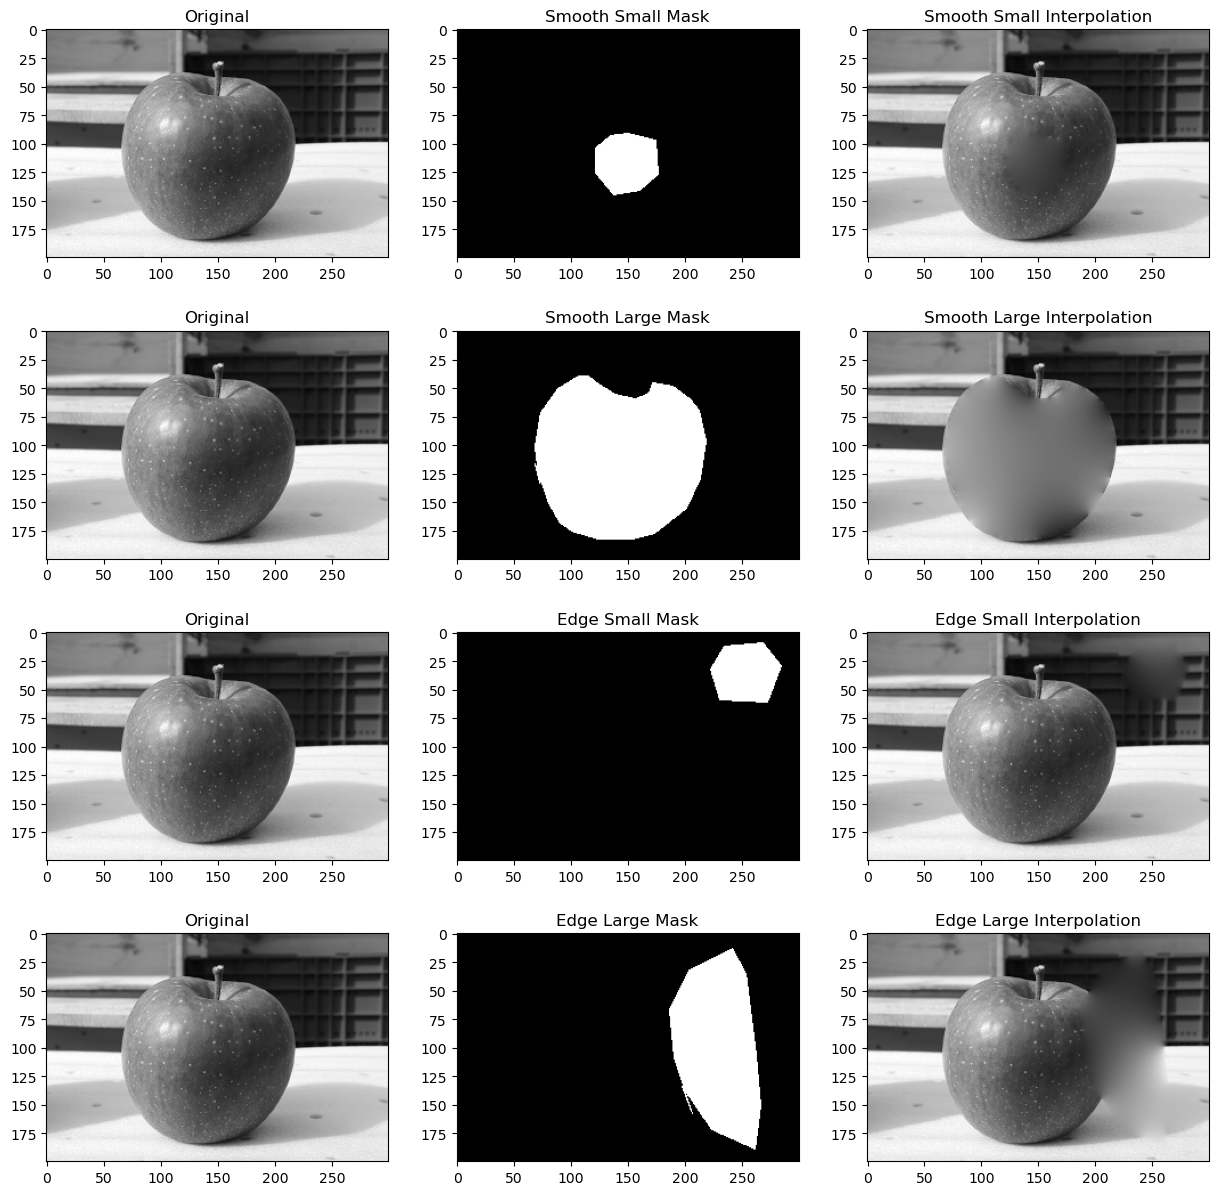

In [65]:
fig, axs = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    axs[i,0].imshow(gray_img, cmap='gray')
    axs[i,0].set_title('Original')
for i, result in enumerate(results):
    mask, target = result
    axs[i,1].imshow(mask, cmap='gray')
    axs[i,2].imshow(target, cmap='gray')
axs[0,1].set_title('Smooth Small Mask')
axs[1,1].set_title('Smooth Large Mask')
axs[2,1].set_title('Edge Small Mask')
axs[3,1].set_title('Edge Large Mask')
axs[0,2].set_title('Smooth Small Interpolation')
axs[1,2].set_title('Smooth Large Interpolation')
axs[2,2].set_title('Edge Small Interpolation')
axs[3,2].set_title('Edge Large Interpolation')

# Task 2

## Importing Gradients

In [66]:
def get_B_ig(indicies, src, target, mask):
    n = len(indicies)
    B = np.zeros(n)
    # For every point in the area, if on edge then equals target pixel otherwise laplace equals 0
    for i, idx in enumerate(indicies):
        if edge(idx, mask):
            B[i] = target[tuple(idx)]
        else:
            neighbours = get_neighbours(idx)
            laplace = 4 * src[tuple(idx)]
            for neighbour in neighbours:
                laplace -= src[tuple(neighbour)]
            B[i] = laplace
    return B

In [67]:
def seamless_cloning_importing_gradients(src, target, points):
    mask = np.zeros_like(src)
    mask = cv.fillPoly(mask, points, 1)
    indicies = get_indices(mask)
    A = get_A(indicies, mask)
    B = get_B_ig(indicies, src, target, mask)
    X = linalg.spsolve(A, B)
    X = np.clip(X, 0, 255)
    result = np.copy(target)
    for i, idx in enumerate(indicies):
        result[idx[0]][idx[1]] = X[i]
    return [mask, result]

In [68]:
sky_gray = cv.imread('img/sky.jpg', cv.IMREAD_GRAYSCALE)
sky_gray = cv.resize(sky_gray, (300, 200))
sky_gray = sky_gray.astype(np.float32)

j20_gray = cv.imread('img/fighter.jpg', cv.IMREAD_GRAYSCALE)
j20_gray = cv.resize(j20_gray, (300, 200))
j20_gray = j20_gray.astype(np.float32)

In [69]:
j20_points = np.load('j20.npy')
# j20_points = add_points_manually(j20_gray/255)
# j20_points = np.expand_dims(j20_points, axis=0)
# np.save('j20', j20_points)

In [70]:
mask, result = seamless_cloning_importing_gradients(j20_gray, sky_gray, j20_points)
plt.imsave('results/task2_importing_gradients.jpg', result, cmap='gray')

Text(0.5, 1.0, 'Seamless Cloning(importing gradients)')

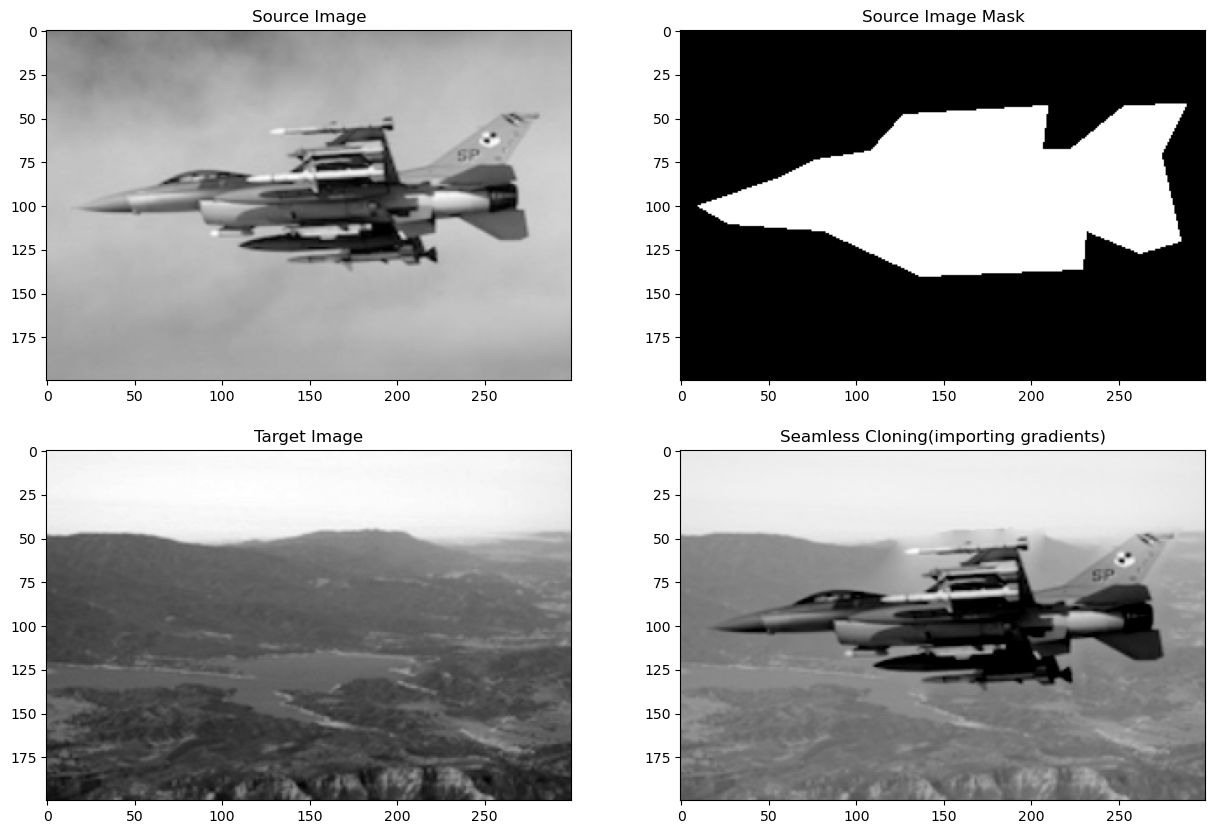

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0,0].imshow(j20_gray, cmap='gray')
axs[0,0].set_title('Source Image')
axs[0,1].imshow(mask, cmap='gray')
axs[0,1].set_title('Source Image Mask')
axs[1,0].imshow(sky_gray, cmap='gray')
axs[1,0].set_title('Target Image')
axs[1,1].imshow(result, cmap='gray')
axs[1,1].set_title('Seamless Cloning(importing gradients)')

## Mixing Gradients

In [72]:
def get_gradients(img, idx):
    neighbours = get_neighbours(idx)
    gradients = []
    for neighbour in neighbours:
        gradients.append(img[tuple(idx)] - img[tuple(neighbour)])
    return gradients

In [88]:
def get_B_mg(indicies, src, target, mask):
    n = len(indicies)
    B = np.zeros(n)
    # For every point in the area, if on edge then equals target pixel otherwise laplace equals 0
    for i, idx in enumerate(indicies):
        if edge(idx, mask):
            B[i] = target[tuple(idx)]
        else:
            laplace = 0
            src_gradients = get_gradients(src, idx)
            target_gradients = get_gradients(target, idx)
            for j in range(4):
                src_gradient = src_gradients[j]
                target_gradient = target_gradients[j]
                laplace += target_gradient if abs(target_gradient) > abs(src_gradient) else src_gradient
            B[i] = laplace
    return B

In [89]:
def seamless_cloning_mixing_gradients(src, target, points):
    mask = np.zeros_like(src)
    mask = cv.fillPoly(mask, points, 1)
    indicies = get_indices(mask)
    A = get_A(indicies, mask)
    B = get_B_mg(indicies, src, target, mask)
    X = linalg.spsolve(A, B)
    X = np.clip(X, 0, 255)
    result = np.copy(target)
    for i, idx in enumerate(indicies):
        result[idx[0]][idx[1]] = X[i]
    return [mask, result]

In [90]:
mask, result = seamless_cloning_mixing_gradients(j20_gray, sky_gray, j20_points)
plt.imsave('results/task2_mixing_gradients.jpg', result, cmap='gray')

Text(0.5, 1.0, 'Seamless Cloning(mixing gradients)')

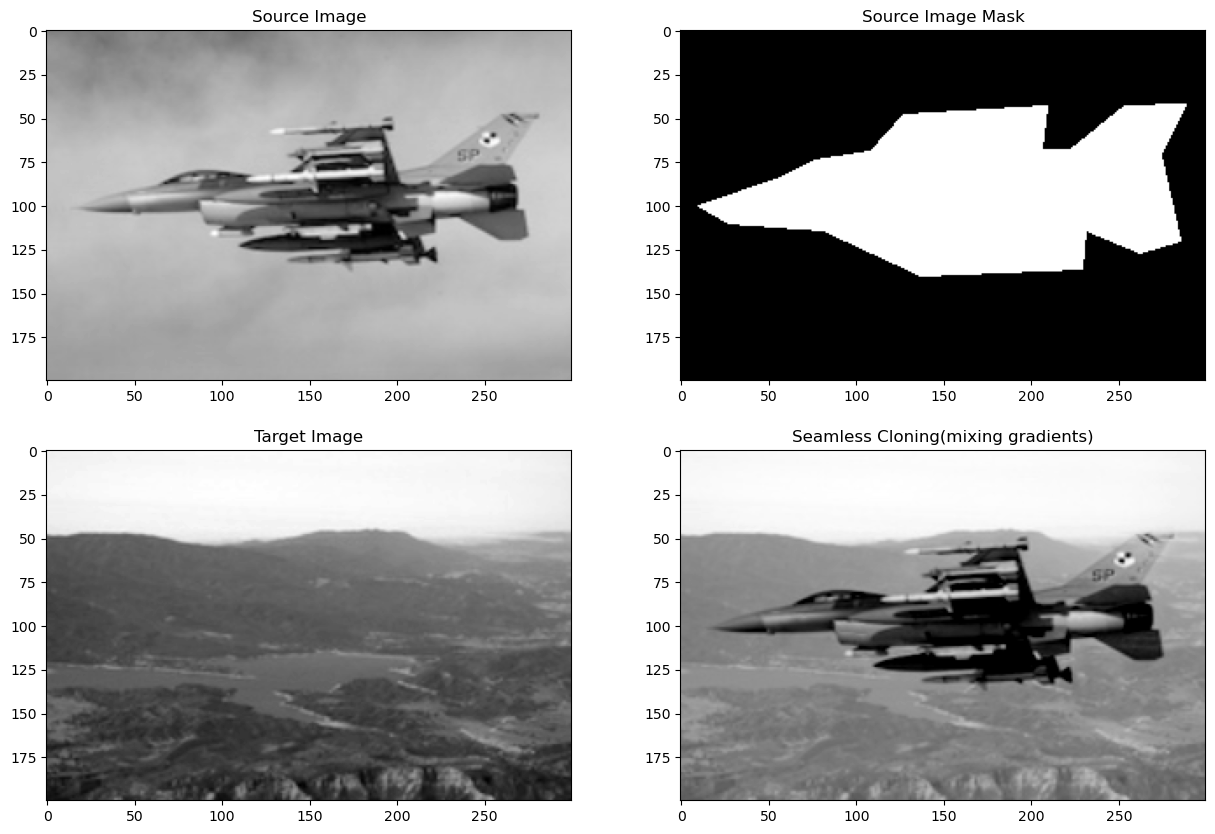

In [91]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0,0].imshow(j20_gray, cmap='gray')
axs[0,0].set_title('Source Image')
axs[0,1].imshow(mask, cmap='gray')
axs[0,1].set_title('Source Image Mask')
axs[1,0].imshow(sky_gray, cmap='gray')
axs[1,0].set_title('Target Image')
axs[1,1].imshow(result, cmap='gray')
axs[1,1].set_title('Seamless Cloning(mixing gradients)')

# Task 3

## RGB for Seamless Cloning(Importing Gradients)

In [77]:
sky_rgb = cv.imread('img/sky.jpg')
sky_rgb = cv.cvtColor(sky_rgb, cv.COLOR_BGR2RGB)
sky_rgb = cv.resize(sky_rgb, (300, 200))
sky_rgb = sky_rgb.astype(np.float32)

j20_rgb = cv.imread('img/fighter.jpg')
j20_rgb = cv.cvtColor(j20_rgb, cv.COLOR_BGR2RGB)
j20_rgb = cv.resize(j20_rgb, (300, 200))
j20_rgb = j20_rgb.astype(np.float32)

In [78]:
def seamless_cloning_importing_gradients_rgb(src, target, points):
    output = np.zeros_like(target)
    for i in range(3):
        src_channel = src[:,:,i]
        target_channel = target[:,:,i]
        mask, result = seamless_cloning_importing_gradients(src_channel, target_channel, points)
        output[:,:,i] = result
    return [mask, output]

In [79]:
mask, result = seamless_cloning_importing_gradients_rgb(j20_rgb, sky_rgb, j20_points)
plt.imsave('results/task3.jpg', result.astype(np.uint8))

Text(0.5, 1.0, 'Seamless Cloning(importing dradients) RGB')

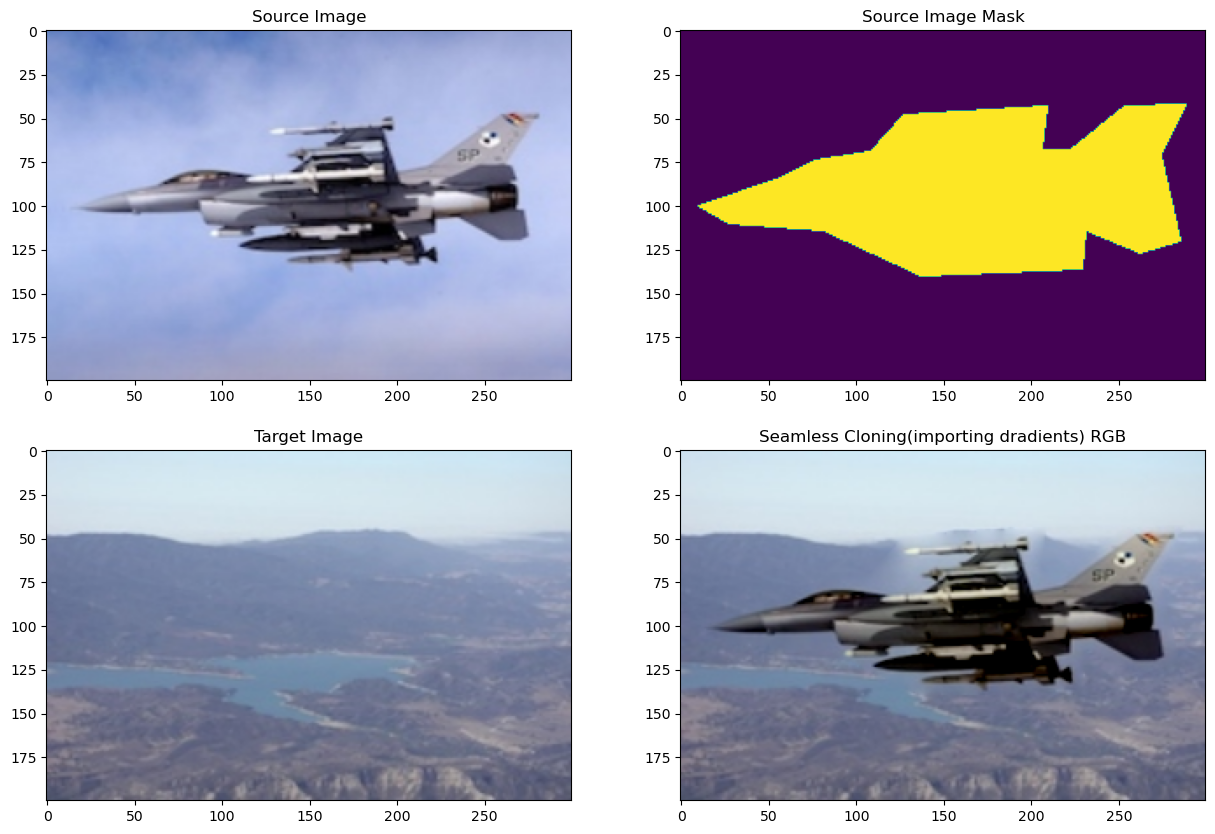

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0,0].imshow(j20_rgb.astype(int))
axs[0,0].set_title('Source Image')
axs[0,1].imshow(mask.astype(int))
axs[0,1].set_title('Source Image Mask')
axs[1,0].imshow(sky_rgb.astype(int))
axs[1,0].set_title('Target Image')
axs[1,1].imshow(result.astype(int))
axs[1,1].set_title('Seamless Cloning(importing dradients) RGB')

# Local Color Change

In [81]:
def get_B_lcc(indicies, img, mask, shift):
    new_img = np.copy(img)
    new_img *= shift
    new_img = np.clip(new_img, 0, 255)
    n = len(indicies)
    B = np.zeros(n)
    # For every point in the area, if on edge then equals target pixel otherwise laplace equals 0
    for i, idx in enumerate(indicies):
        if edge(idx, mask):
            B[i] = img[tuple(idx)]
        else:
            # src_gradients = get_gradients(src, idx)
            laplace = 4 * new_img[tuple(idx)]
            neighbours = get_neighbours(idx)
            for neighbour in neighbours:
                laplace -= new_img[tuple(neighbour)]
            B[i] = laplace
    return B

In [82]:
def color_change(img, points, shift):
    mask = np.zeros_like(img[:,:,0])
    mask = cv.fillPoly(mask, points, 1)
    indicies = get_indices(mask)
    A = get_A(indicies, mask)
    results = np.zeros_like(img)
    for i in range(3):
        B = get_B_lcc(indicies, img[:,:,i], mask, shift[i])
        X = linalg.spsolve(A, B)
        result = np.copy(img[:,:,i])
        for j, idx in enumerate(indicies):
            result[idx[0]][idx[1]] = X[j]
        results[:,:,i] = result
    return [mask, results]

In [83]:
flower_rgb = cv.imread('img/flower.png')
flower_rgb = cv.cvtColor(flower_rgb, cv.COLOR_BGR2RGB)
flower_rgb = cv.resize(flower_rgb, (300, 200))
flower_rgb = flower_rgb.astype(np.float32)

In [84]:
flower_points = np.load('flower.npy')
# tmp = cv.cvtColor(flower_rgb, cv.COLOR_RGB2BGR)
# flower_points = add_points_manually(tmp.astype(np.uint8))
# flower_points = np.expand_dims(flower_points, axis=0)
# np.save('flower', flower_points)

In [85]:
shift = [0.9412, 0.4627, 0.5451]
shift /= np.mean(shift)
mask, result = color_change(flower_rgb, flower_points, shift)
plt.imsave('results/task4_local_color_change.jpg', result.astype(np.uint8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Local Color Change')

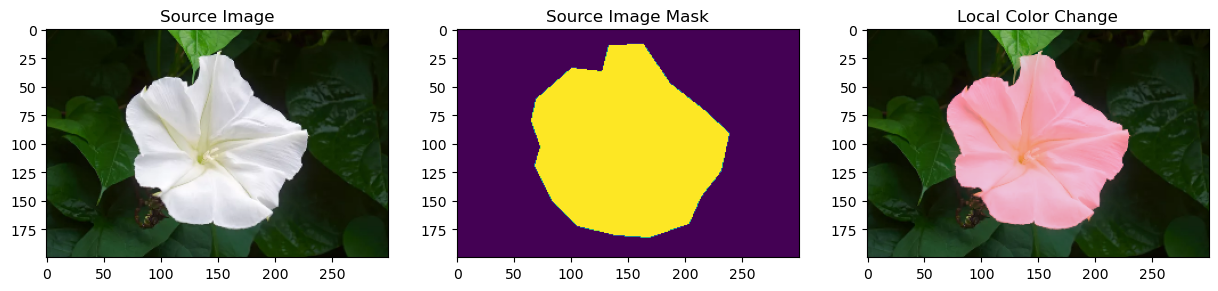

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(15,10))
axs[0].imshow(flower_rgb.astype(int))
axs[0].set_title('Source Image')
axs[1].imshow(mask.astype(int))
axs[1].set_title('Source Image Mask')
axs[2].imshow(result.astype(int))
axs[2].set_title('Local Color Change')